# Experiment 7
Aim : Apply value iteration algorithm to specific application

To improve the theory of **Value Iteration** in the context of solving a **Grid World Problem**, we can refine and expand upon the key concepts, ensuring a deeper understanding of the algorithm's mechanics, convergence properties, and practical considerations. Below is an enhanced version of the theory:

---

### **Enhanced Theory of Value Iteration for Grid World Problems**

#### **1. Markov Decision Process (MDP) Formulation**
A Grid World is a classic MDP where:
- **States (S):** Represent grid cells (e.g., `(x,y)` coordinates).
- **Actions (A):** Discrete movements (up, down, left, right). In stochastic environments, actions may fail with some probability (e.g., slipping to adjacent states).
- **Rewards (R):**  
  - `+R_g` for reaching the goal state.  
  - `-R_s` for each step (encourages efficiency).  
  - `-R_o` for hitting obstacles/walls (optional).  
  - `0` elsewhere (or a small negative reward to discourage lingering).  
- **Transition Model (T):**  
  - Deterministic: Action `a` leads to intended state `s'` with probability `1.0`.  
  - Stochastic: With probability `p`, the agent moves as intended; with `1−p`, it may slip to neighboring states.  

#### **2. Value Function and Optimality**
- The **value function** `V(s)` estimates the expected **discounted cumulative reward** from state `s` under the optimal policy.  
- The **Bellman Optimality Equation** defines the optimal value:  
  \[
  V^*(s) = \max_{a} \left[ R(s,a) + \gamma \sum_{s'} T(s' \mid s, a) V^*(s') \right]
  \]
  where:
  - `γ ∈ (0,1]` is the **discount factor** (balances immediate vs. future rewards).  
  - `T(s' | s, a)` is the transition probability to `s'` given action `a` in `s`.  

#### **3. Value Iteration Algorithm**
1. **Initialization:**  
   - Set `V(s) = 0` for all states (or arbitrary values).  
   - Define a small threshold `θ` (e.g., `θ = 1e-6`) for convergence.  

2. **Iterative Update:**  
   Repeat until `max_s |V_{k+1}(s) - V_k(s)| < θ`:  
   - For each state `s`, update:  
     \[
     V(s) \leftarrow \max_{a} \left[ R(s,a) + \gamma \sum_{s'} T(s' \mid s, a) V(s') \right]
     \]
   - For deterministic grids, the transition simplifies to `V(s) ← max_a [R(s,a) + γV(s')]`, where `s'` is the next state.  

3. **Policy Extraction:**  
   After convergence, derive the optimal policy `π^*(s)` by greedily selecting actions:  
   \[
   π^*(s) = \arg\max_{a} \left[ R(s,a) + \gamma \sum_{s'} T(s' \mid s, a) V(s') \right]
   \]

#### **4. Convergence and Properties**
- **Guaranteed Convergence:** Value iteration converges to `V^*` for any finite MDP due to the **Contraction Mapping Theorem** (the Bellman operator is a contraction).  
- **Stopping Condition:** The algorithm terminates when the maximum change in `V(s)` (called the **Bellman Error**) is below `θ`.  
- **Discount Factor (`γ`):**  
  - `γ ≈ 1`: Far-sighted agent (values long-term rewards).  
  - `γ ≈ 0`: Myopic agent (prioritizes immediate rewards).  

#### **5. Practical Enhancements for Grid World**
- **Obstacle Handling:** Assign `V(s) = -∞` (or a large negative penalty) to blocked states.  
- **Early Termination:** Stop updates for the goal state (`V(goal) = R_g`).  
- **Asynchronous Updates:** Prioritize states with larger Bellman error to speed up convergence.  

#### **6. Example (Deterministic 3x3 Grid)**
- **States:** `(0,0)` to `(2,2)`; Goal at `(2,2)`.  
- **Rewards:** `R_g = +10`, `R_s = -1`, `γ = 0.9`.  
- **Value Iteration Steps:**  
  - Initialize `V(s) = 0`.  
  - After first iteration:  
    - `V(2,2) = 10` (goal).  
    - Adjacent states: `V(1,2) = -1 + 0.9*10 = 8`.  
  - Repeat until values stabilize.  

#### **7. Extensions**
- **Stochastic Transitions:** Modify `T(s' | s, a)` to reflect slippage (e.g., 80% intended move, 20% random adjacent).  
- **Q-Value Iteration:** Track `Q(s,a)` instead of `V(s)` for direct policy extraction.  

---

### **Key Improvements Over Basic Theory**
1. **Clarified Transition Model:** Explicitly distinguishes deterministic vs. stochastic cases.  
2. **Convergence Conditions:** Adds mathematical justification (Contraction Mapping).  
3. **Practical Tips:** Includes obstacle handling and early termination.  
4. **Parameter Insights:** Discusses the role of `γ` and `θ`.  
5. **Example Integration:** Links theory to a concrete grid scenario.  

This refined theory provides a stronger foundation for implementing value iteration in grid worlds and understanding its convergence behavior.

In [ ]:
!pip install -qq gym==0.23.0


from typing import Tuple, Dict, Optional, Iterable, Callable

import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import animation

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw


class Maze(gym.Env):

    def __init__(self, exploring_starts: bool = False,
                 shaped_rewards: bool = False, size: int = 5) -> None:
        super().__init__()
        self.exploring_starts = exploring_starts
        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        reward = self.compute_reward(self.state, action)
        self.state = self._get_next_state(self.state, action)
        done = self.state == self.goal
        info = {}
        return self.state, reward, done, info

    def reset(self) -> Tuple[int, int]:
        if self.exploring_starts:
            while self.state == self.goal:
                self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state

    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 5

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))


        for row in range(5):
            for col in range(5):

                state = (row, col)
                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (5 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (5 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 4 + 10, scale * 5 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        next_state = self._get_next_state(state, action)
        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info

    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], Iterable[Tuple[int, int]]]:
        maze = {(row, col): [(row - 1, col), (row + 1, col), (row, col - 1), (row, col + 1)]
                for row in range(size) for col in range(size)}

        left_edges = [[(row, 0), (row, -1)] for row in range(size)]
        right_edges = [[(row, size - 1), (row, size)] for row in range(size)]
        upper_edges = [[(0, col), (-1, col)] for col in range(size)]
        lower_edges = [[(size - 1, col), (size, col)] for col in range(size)]
        walls = [
            [(1, 0), (1, 1)], [(2, 0), (2, 1)], [(3, 0), (3, 1)],
            [(1, 1), (1, 2)], [(2, 1), (2, 2)], [(3, 1), (3, 2)],
            [(3, 1), (4, 1)], [(0, 2), (1, 2)], [(1, 2), (1, 3)],
            [(2, 2), (3, 2)], [(2, 3), (3, 3)], [(2, 4), (3, 4)],
            [(4, 2), (4, 3)], [(1, 3), (1, 4)], [(2, 3), (2, 4)],
        ]

        obstacles = upper_edges + lower_edges + left_edges + right_edges + walls

        for src, dst in obstacles:
            maze[src].remove(dst)

            if dst in maze:
                maze[dst].remove(src)

        return maze

    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        distances = np.full((5, 5), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 5, v % 5) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


def plot_policy(probs_or_qvals, frame, action_meanings=None):
    if action_meanings is None:
        action_meanings = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    probs_copy = max_prob_actions.copy().astype(object)
    for key in action_meanings:
        probs_copy[probs_copy == key] = action_meanings[key]
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.suptitle("Policy", size=18)
    plt.tight_layout()


def plot_values(state_values, frame):
    f, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(state_values, annot=True, fmt=".2f", cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.tight_layout()


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def test_agent(environment, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render(mode="rgb_array"))

        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, reward, done, extra_info = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            state = next_state

    return display_video(frames)

In [ ]:
import gym
import numpy as np
from IPython import display
from matplotlib import pyplot as plt

In [ ]:
env = Maze()

In [ ]:
env.reset()

(0, 0)

In [ ]:
frame = env.render(mode='rgb_array')
plt.imshow(frame)

In [ ]:
policy_probs = np.full((5,5,4),0.25)


In [ ]:
policy_probs

array([[[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]],

       [[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]]])

In [ ]:
policy_probs.shape

(5, 5, 4)

In [ ]:
def policy(state):
  return policy_probs[state]


In [ ]:
action_probabilities = policy((0,0))
for action, prob in zip(range(4), action_probabilities):
  print(f"Probability of taking action {action} is {prob}")

Probability of taking action 0 is 0.25
Probability of taking action 1 is 0.25
Probability of taking action 2 is 0.25
Probability of taking action 3 is 0.25


In [ ]:
test_agent(env,policy,episodes=1)

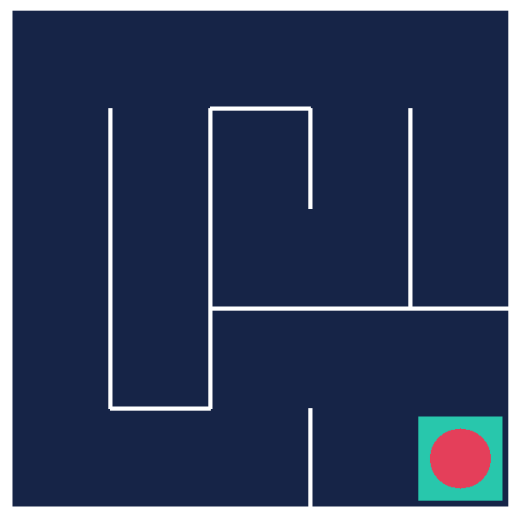

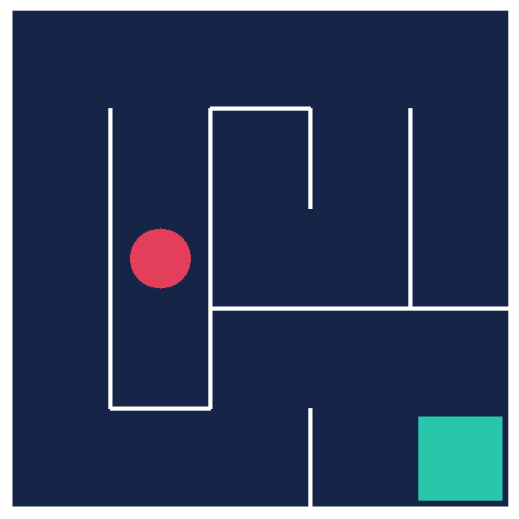

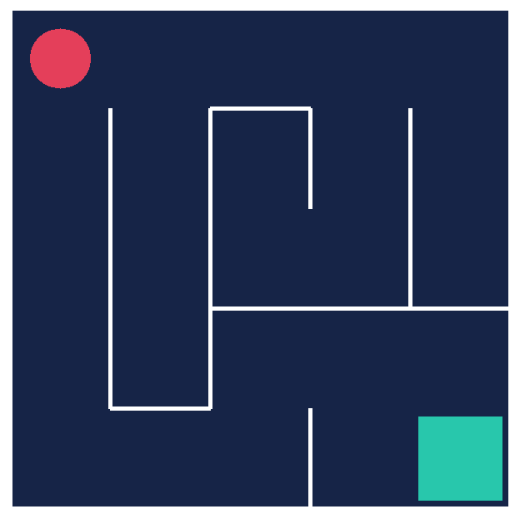

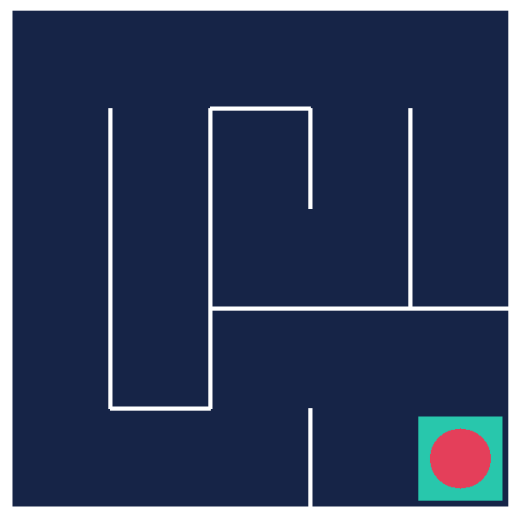

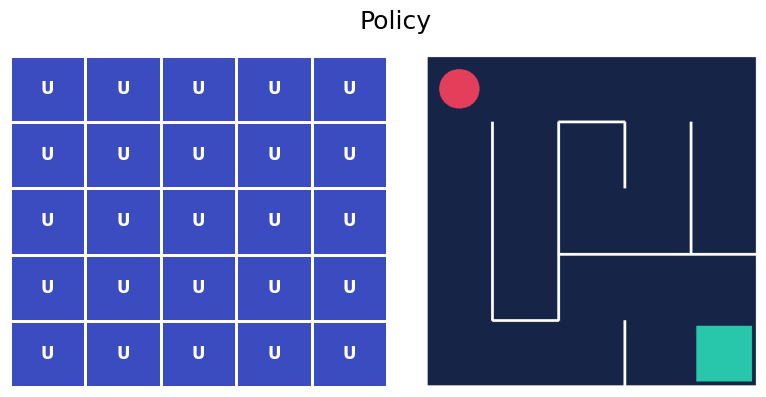

In [ ]:
plot_policy(policy_probs, frame)

In [ ]:
#value based Iteration
state_values = np.zeros((5,5))

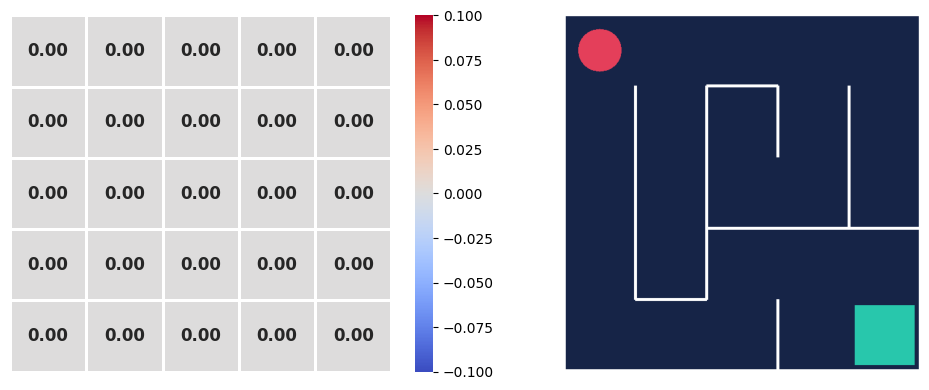

In [ ]:
plot_values(state_values, frame)

In [ ]:
def value_iteration(policy_probs, state_values, theta = 1e-6, gamma=0.99):
  delta = float('inf')
#delta = [(n-1)iteration ka value - nth iteration ka value];theta = threshold
  while delta>theta:
    delta = 0
    for row in range(5):
      for col in range(5):
        old_value = state_values[(row,col)]
        action_probs = None
        max_qsa = float('-inf')

        for action in range(4):
          next_state,reward, _, _ = env.simulate_step((row,col),action)
          qsa = reward + gamma * state_values[next_state]
          if qsa > max_qsa:
            max_qsa = qsa
            action_probs = np.zeros(4)
            action_probs[action]=1

        state_values[(row, col)] = max_qsa
        policy_probs[(row, col)] = action_probs
        delta = max(delta,abs(max_qsa - old_value))


In [ ]:
value_iteration(policy_probs,state_values)

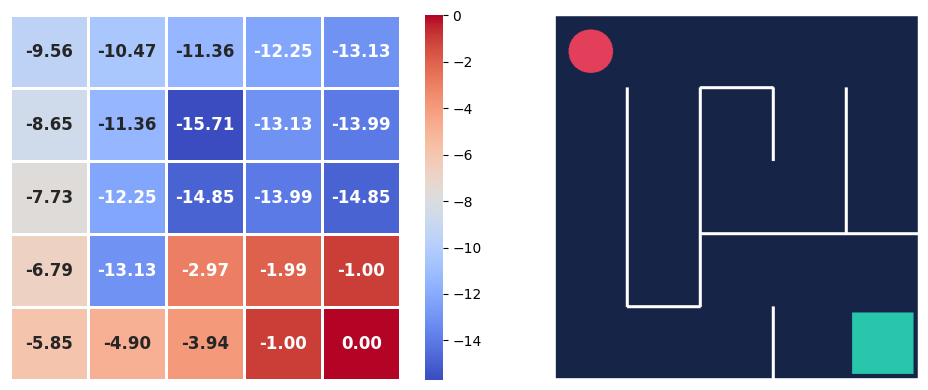

In [ ]:
plot_values(state_values,frame)

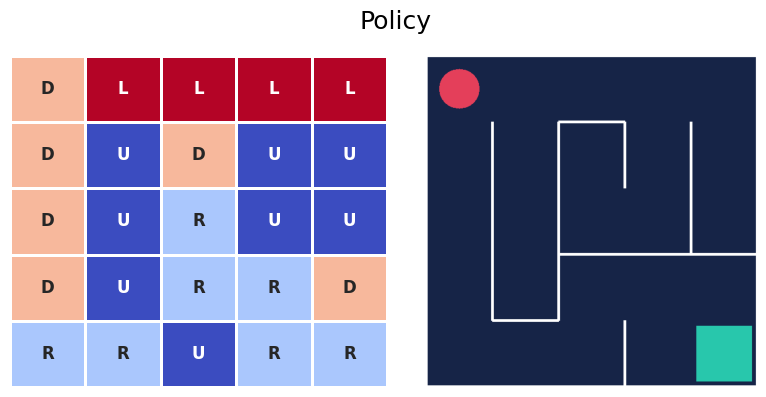

In [ ]:
plot_policy(policy_probs, frame)

In [ ]:
test_agent(env,policy,episodes=1)

### **Conclusion**  

Value Iteration is a powerful **dynamic programming** algorithm for solving **Markov Decision Processes (MDPs)** and finding optimal policies in reinforcement learning tasks like the **Grid World Problem**. By iteratively updating the value function using the **Bellman Optimality Equation**, the algorithm guarantees convergence to the optimal policy, provided the MDP is finite and fully known.  

#### **Key Takeaways**  
1. **Optimality & Convergence:**  
   - Value Iteration converges to the **optimal value function** \( V^* \) and, consequently, the **optimal policy** \( \pi^* \).  
   - The algorithm’s convergence is ensured by the **Contraction Mapping Theorem**, with stopping criteria based on a small threshold \( \theta \).  

2. **Practical Considerations:**  
   - **Discount factor (\( \gamma \))** balances immediate vs. future rewards.  
   - **Reward design** (step penalties, goal rewards) influences agent behavior.  
   - **Deterministic vs. Stochastic transitions** affect how actions are modeled.  

3. **Applications Beyond Grid World:**  
   - Value Iteration is foundational for more advanced RL methods like **Q-Learning** and **Policy Iteration**.  
   - It is widely used in robotics, path planning, and game AI where model dynamics are known.  

